In [1]:
from Threshold import binarize
from Morphology import erode, dilate
from Contour import keep_largest_contour
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [2]:
# image_raw = cv2.imread('eyes/6L1.bmp', 0)
# image_raw = cv2.imread('/Users/mateuszdeptuch/SCHOOL/Biometria/Biometria2/teczowka_data/034/IMG_034_L_5.JPG', 0)
image_raw = cv2.imread('/Users/mateuszdeptuch/SCHOOL/Biometria/Biometria2/teczowka_data/028/IMG_028_L_3.JPG', 0)

# TODO

- dobrać operacje morfologiczne dla tęczówki
- przetestować na wszystkich osobach chociaż
- ewentualnie zrobić skośne projekcje
- rozwijanie tęczówki
- raport
- ewentualnie wrzucić na streamlita
- ewentualnie zrobić jakoś lepiej wykrywanie promienia tęczówki
- rozpoznawanie na podstawie rozwiniętej tęczówki

# detekcja źrenicy

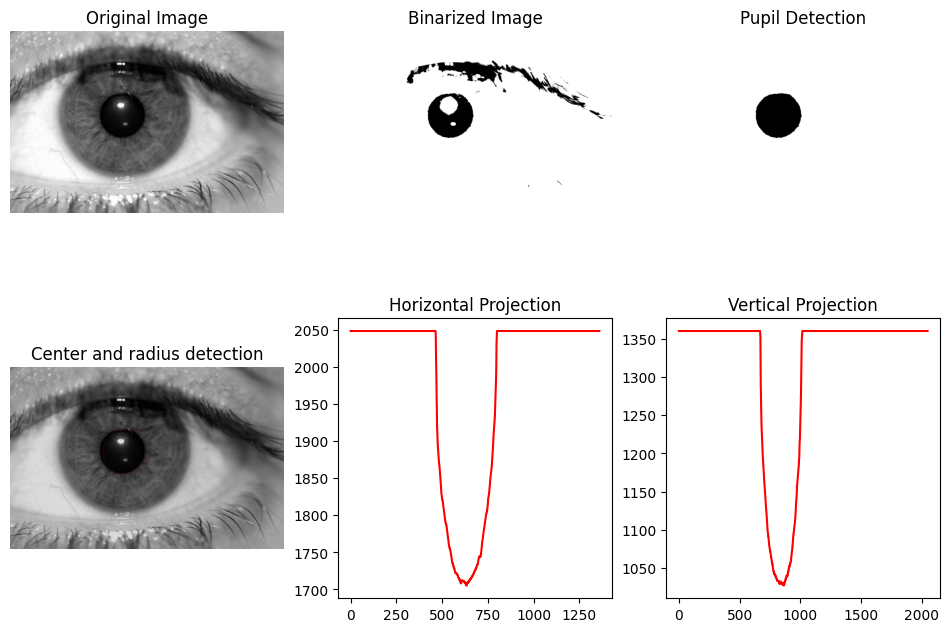

In [3]:
image_bin = binarize(image_raw, threshold=0.22)

# czyszczenie
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
image = cv2.erode(image_bin, kernel, iterations=2)
image = cv2.dilate(image, kernel, iterations=2)
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
image = cv2.medianBlur(image, 5)
image = keep_largest_contour(image)

# projekcja
binary_image = (image > 0).astype(np.uint8)
horizontal_proj = np.sum(binary_image, axis=1)
vertical_proj = np.sum(binary_image, axis=0)

# środek
x = int(np.mean(np.where(vertical_proj == np.min(vertical_proj))[0]))
y = int(np.mean(np.where(horizontal_proj == np.min(horizontal_proj))[0]))

# promień
left_edge = np.min(np.where(vertical_proj < max(vertical_proj)))
right_edge = np.max(np.where(vertical_proj < max(vertical_proj)))
radius_horizontal = (right_edge - left_edge) // 2

top_edge = np.min(np.where(horizontal_proj < max(horizontal_proj)))
bottom_edge = np.max(np.where(horizontal_proj < max(horizontal_proj)))
radius_vertical = (bottom_edge - top_edge) // 2

radius_pupil = (radius_horizontal + radius_vertical) // 2

# zaznaczenie środka i promienia
image_center = cv2.cvtColor(image_raw.copy(), cv2.COLOR_GRAY2BGR)
image_center = cv2.circle(image_center, (x, y), radius_pupil, (255, 0, 0), 1)
image_center = cv2.circle(image_center, (x, y), 0, (255, 0, 0), 5)

# wyświetlenie zdjęć i wykresów
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1); plt.imshow(image_raw, cmap='gray'); plt.title('Original Image'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(image_bin, cmap='gray'); plt.title('Binarized Image'); plt.axis('off') 
plt.subplot(2, 3, 3); plt.imshow(image, cmap='gray'); plt.title('Pupil Detection'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(image_center); plt.title('Center and radius detection'); plt.axis('off')
plt.subplot(2, 3, 5); plt.plot(horizontal_proj, color='red'); plt.title('Horizontal Projection')
plt.subplot(2, 3, 6); plt.plot(vertical_proj, color='red'); plt.title('Vertical Projection')
plt.show()

# detekcja tęczówki

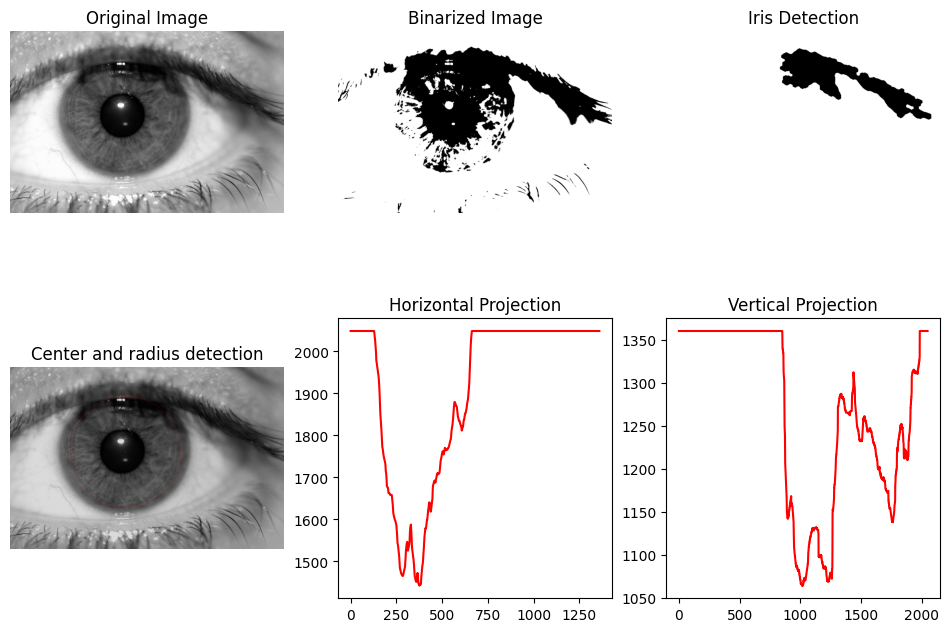

In [ ]:
mask_pupil = np.zeros_like(image_raw)
cv2.circle(mask_pupil, (x, y), radius_pupil, 255, thickness=-1)

# Step 2: Create a circular mask for the entire region (outer area)
mask_outer = np.ones_like(image_raw) * 255
cv2.circle(mask_outer, (x, y), radius_pupil, 0, thickness=-1)  # Invert the mask to exclude pupil

# Step 3: Mask the image with the outer region to get brightness outside the pupil
outer_region = cv2.bitwise_and(image_raw, image_raw, mask=mask_outer)

# Step 4: Calculate the mean brightness in the outer region (around the iris)
mean_brightness = np.mean(outer_region[mask_outer > 0])

# Step 5: Set a dynamic threshold based on the mean brightness of the outer region
threshold = mean_brightness / 255 *1.22
    # Relative thresholding

# Step 6: Binarize using the dynamically calculated threshold
image_bin = binarize(image_raw, threshold=threshold)

# czyszczenie
small_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
image = cv2.dilate(image_bin, big_kernel, iterations=9)
image = cv2.erode(image, small_kernel, iterations=2)
image = keep_largest_contour(image)
image = cv2.erode(image, big_kernel, iterations=4)

# projekcja
binary_image = (image > 0).astype(np.uint8)
horizontal_proj = np.sum(binary_image, axis=1)
vertical_proj = np.sum(binary_image, axis=0)

# promień
left_edge = np.min(np.where(vertical_proj < max(vertical_proj)))
right_edge = np.max(np.where(vertical_proj < max(vertical_proj)))
radius_horizontal = (right_edge - left_edge) // 2

top_edge = np.min(np.where(horizontal_proj < max(horizontal_proj)))
bottom_edge = np.max(np.where(horizontal_proj < max(horizontal_proj)))
radius_vertical = (bottom_edge - top_edge) // 2

radius_iris = (radius_horizontal + radius_vertical) // 2

# zaznaczenie środka i promienia
image_center = cv2.cvtColor(image_raw.copy(), cv2.COLOR_GRAY2BGR)
image_center = cv2.circle(image_center, (x, y), radius_iris, (255, 0, 0), 1)
image_center = cv2.circle(image_center, (x, y), 0, (255, 0, 0), 5)

# wyświetlenie zdjęć i wykresów
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1); plt.imshow(image_raw, cmap='gray'); plt.title('Original Image'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(image_bin, cmap='gray'); plt.title('Binarized Image'); plt.axis('off') 
plt.subplot(2, 3, 3); plt.imshow(image, cmap='gray'); plt.title('Iris Detection'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(image_center); plt.title('Center and radius detection'); plt.axis('off')
plt.subplot(2, 3, 5); plt.plot(horizontal_proj, color='red'); plt.title('Horizontal Projection')
plt.subplot(2, 3, 6); plt.plot(vertical_proj, color='red'); plt.title('Vertical Projection')
plt.show()

### rozne proby doboru parametrow

In [5]:
# for image in os.listdir('eyes')[20:30]:
#     image_raw = cv2.imread(os.path.join('eyes', image), 0)
#     image_bin = binarize(image_raw, threshold=0.22)

#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     image = cv2.erode(image_bin, kernel, iterations=2)
#     image = cv2.dilate(image, kernel, iterations=2)
#     image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)
#     image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
#     image = cv2.medianBlur(image, 5)
#     image = keep_largest_contour(image)

#     # projekcja
#     binary_image = (image > 0).astype(np.uint8)
#     horizontal_proj = np.sum(binary_image, axis=1)
#     vertical_proj = np.sum(binary_image, axis=0)

#     # środek
#     x = int(np.mean(np.where(vertical_proj == np.min(vertical_proj))[0]))
#     y = int(np.mean(np.where(horizontal_proj == np.min(horizontal_proj))[0]))

#     # promień
#     left_edge = np.min(np.where(vertical_proj < max(vertical_proj)))
#     right_edge = np.max(np.where(vertical_proj < max(vertical_proj)))
#     radius_horizontal = (right_edge - left_edge) // 2

#     top_edge = np.min(np.where(horizontal_proj < max(horizontal_proj)))
#     bottom_edge = np.max(np.where(horizontal_proj < max(horizontal_proj)))
#     radius_vertical = (bottom_edge - top_edge) // 2

#     radius_pupil = (radius_horizontal + radius_vertical) // 2

#     # zaznaczenie środka i promienia
#     image_center = cv2.cvtColor(image_raw.copy(), cv2.COLOR_GRAY2BGR)
#     image_center = cv2.circle(image_center, (x, y), radius_pupil, (255, 0, 0), 1)
#     image_center = cv2.circle(image_center, (x, y), 0, (255, 0, 0), 5)

#     # wyświetlenie zdjęć i wykresów
#     plt.figure(figsize=(4,4))
#     plt.imshow(image_center); plt.title('Center and radius detection'); plt.axis('off')
#     plt.show()




#     mask_pupil = np.zeros_like(image_raw)
#     cv2.circle(mask_pupil, (x, y), radius_pupil, 255, thickness=-1)

#     # Step 2: Create a circular mask for the entire region (outer area)
#     mask_outer = np.ones_like(image_raw) * 255
#     cv2.circle(mask_outer, (x, y), radius_pupil, 0, thickness=-1)  # Invert the mask to exclude pupil

#     # Step 3: Mask the image with the outer region to get brightness outside the pupil
#     outer_region = cv2.bitwise_and(image_raw, image_raw, mask=mask_outer)

#     # Step 4: Calculate the mean brightness in the outer region (around the iris)
#     mean_brightness = np.mean(outer_region[mask_outer > 0])

#     # Step 5: Set a dynamic threshold based on the mean brightness of the outer region
#     threshold = mean_brightness / 255 *1.22
#      # Relative thresholding

#     # Step 6: Binarize using the dynamically calculated threshold
#     image_bin = binarize(image_raw, threshold=threshold)


#     # image_bin = binarize(image_raw, threshold=0.6)
#     # czyszczenie
#     small_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
#     big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     image = cv2.dilate(image_bin, big_kernel, iterations=10)
#     image = cv2.erode(image, small_kernel, iterations=2)
#     image = keep_largest_contour(image)
#     image = cv2.erode(image, big_kernel, iterations=8)

#     # projekcja
#     binary_image = (image > 0).astype(np.uint8)
#     horizontal_proj = np.sum(binary_image, axis=1)
#     vertical_proj = np.sum(binary_image, axis=0)

#     # promień
#     left_edge = np.min(np.where(vertical_proj < max(vertical_proj)))
#     right_edge = np.max(np.where(vertical_proj < max(vertical_proj)))
#     radius_horizontal = (right_edge - left_edge) // 2

#     top_edge = np.min(np.where(horizontal_proj < max(horizontal_proj)))
#     bottom_edge = np.max(np.where(horizontal_proj < max(horizontal_proj)))
#     radius_vertical = (bottom_edge - top_edge) // 2

#     radius_iris = (radius_horizontal + radius_vertical) // 2

#     # zaznaczenie środka i promienia
#     image_center = cv2.cvtColor(image_raw.copy(), cv2.COLOR_GRAY2BGR)
#     image_center = cv2.circle(image_center, (x, y), radius_iris, (255, 0, 0), 1)
#     image_center = cv2.circle(image_center, (x, y), 0, (255, 0, 0), 5)

#     # wyświetlenie zdjęć i wykresów
#     plt.figure(figsize=(4, 4))

#     plt.imshow(image_center); plt.title('Center and radius detection'); plt.axis('off')

#     plt.show()

In [6]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from ipywidgets import interact, IntSlider

# image_raw = cv2.imread('/Users/mateuszdeptuch/SCHOOL/Biometria/Biometria2/teczowka_data/028/IMG_028_R_1.JPG', 0)

# def process_image(dilate_iter=2, erode_iter=2, final_erode_iter=5):

#     image_bin = binarize(image_raw, threshold=0.22)

# # czyszczenie
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 100))
#     image = cv2.erode(image_bin, kernel, iterations=2)
#     image = cv2.dilate(image, kernel, iterations=2)
#     image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)
#     image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
#     image = cv2.medianBlur(image, 5)
#     image = keep_largest_contour(image)

#     # projekcja
#     binary_image = (image > 0).astype(np.uint8)
#     horizontal_proj = np.sum(binary_image, axis=1)
#     vertical_proj = np.sum(binary_image, axis=0)

#     # środek
#     x = int(np.mean(np.where(vertical_proj == np.min(vertical_proj))[0]))
#     y = int(np.mean(np.where(horizontal_proj == np.min(horizontal_proj))[0]))

#     # promień
#     left_edge = np.min(np.where(vertical_proj < max(vertical_proj)))
#     right_edge = np.max(np.where(vertical_proj < max(vertical_proj)))
#     radius_horizontal = (right_edge - left_edge) // 2

#     top_edge = np.min(np.where(horizontal_proj < max(horizontal_proj)))
#     bottom_edge = np.max(np.where(horizontal_proj < max(horizontal_proj)))
#     radius_vertical = (bottom_edge - top_edge) // 2

#     radius_pupil = (radius_horizontal + radius_vertical) // 2


#     mask_pupil = np.zeros_like(image_raw)
#     cv2.circle(mask_pupil, (x, y), radius_pupil, 255, thickness=-1)

#     # Step 2: Create a circular mask for the entire region (outer area)
#     mask_outer = np.ones_like(image_raw) * 255
#     cv2.circle(mask_outer, (x, y), radius_pupil, 0, thickness=-1)  # Invert the mask to exclude pupil

#     # Step 3: Mask the image with the outer region to get brightness outside the pupil
#     outer_region = cv2.bitwise_and(image_raw, image_raw, mask=mask_outer)

#     # Step 4: Calculate the mean brightness in the outer region (around the iris)
#     mean_brightness = np.mean(outer_region[mask_outer > 0])

#     # Step 5: Set a dynamic threshold based on the mean brightness of the outer region
#     threshold = mean_brightness / 255 * 1.22 # Relative thresholding

#     # Step 6: Binarize using the dynamically calculated threshold
#     image_bin = binarize(image_raw, threshold=threshold)


#     # image_bin = binarize(image_raw, threshold=0.6)
#     # czyszczenie
#     small_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
#     big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     image = cv2.dilate(image_bin, big_kernel, iterations=dilate_iter)
#     image = cv2.erode(image, small_kernel, iterations=erode_iter)
#     image = keep_largest_contour(image)
#     image = cv2.erode(image, big_kernel, iterations=final_erode_iter)

#     # projekcja
#     binary_image = (image > 0).astype(np.uint8)
#     horizontal_proj = np.sum(binary_image, axis=1)
#     vertical_proj = np.sum(binary_image, axis=0)

#     # promień
#     left_edge = np.min(np.where(vertical_proj < max(vertical_proj)))
#     right_edge = np.max(np.where(vertical_proj < max(vertical_proj)))
#     radius_horizontal = (right_edge - left_edge) // 2

#     top_edge = np.min(np.where(horizontal_proj < max(horizontal_proj)))
#     bottom_edge = np.max(np.where(horizontal_proj < max(horizontal_proj)))
#     radius_vertical = (bottom_edge - top_edge) // 2

#     radius_iris = (radius_horizontal + radius_vertical) // 2

#     # zaznaczenie środka i promienia
#     image_center = cv2.cvtColor(image_raw.copy(), cv2.COLOR_GRAY2BGR)
#     image_center = cv2.circle(image_center, (x, y), radius_iris, (255, 0, 0), 1)
#     image_center = cv2.circle(image_center, (x, y), 0, (255, 0, 0), 5)


#     # Display images and plots
#     plt.figure(figsize=(12, 8))
#     plt.subplot(2, 3, 1); plt.imshow(image_raw, cmap='gray'); plt.title('Original Image'); plt.axis('off')
#     plt.subplot(2, 3, 2); plt.imshow(image_bin, cmap='gray'); plt.title('Binarized Image'); plt.axis('off')
#     plt.subplot(2, 3, 3); plt.imshow(image, cmap='gray'); plt.title('Iris Detection'); plt.axis('off')
#     plt.subplot(2, 3, 4); plt.imshow(image_center); plt.title('Center and radius detection'); plt.axis('off')
#     plt.subplot(2, 3, 5); plt.plot(horizontal_proj, color='red'); plt.title('Horizontal Projection')
#     plt.subplot(2, 3, 6); plt.plot(vertical_proj, color='red'); plt.title('Vertical Projection')
#     plt.tight_layout()
#     plt.show()

# # Create interactive sliders
# interact(process_image,
#          dilate_iter=IntSlider(min=0, max=15, step=1, value=2, description='Dilate Iterations'),
#          erode_iter=IntSlider(min=0, max=15, step=1, value=2, description='Erode Iterations'),
#          final_erode_iter=IntSlider(min=0, max=15, step=1, value=5, description='Final Erode Iterations'));


# rozwijanie tęczówki

In [7]:
def normalize_iris(image, x, y, r_pupil, r_iris, height=64, width=512):
    """
    Normalize the iris region into a rectangular image.

    Parameters:
    - image: grayscale eye image
    - x, y: center of the pupil and iris (assumed same)
    - r_pupil: pupil radius
    - r_iris: iris radius
    - height: vertical resolution (r steps)
    - width: horizontal resolution (theta steps)

    Returns:
    - normalized iris image
    """
    theta = np.linspace(0, 2 * np.pi, width)
    r = np.linspace(0, 1, height)

    # Create grid for polar coords
    r_grid, theta_grid = np.meshgrid(r, theta)

    # Interpolate from pupil to iris boundary
    x_pupil = x + r_pupil * np.cos(theta_grid)
    y_pupil = y + r_pupil * np.sin(theta_grid)
    x_iris = x + r_iris * np.cos(theta_grid)
    y_iris = y + r_iris * np.sin(theta_grid)

    # Linear interpolation between pupil and iris
    x_coords = (1 - r_grid) * x_pupil + r_grid * x_iris
    y_coords = (1 - r_grid) * y_pupil + r_grid * y_iris

    # Map coordinates to image
    x_coords = np.clip(x_coords, 0, image.shape[1] - 1).astype(np.float32)
    y_coords = np.clip(y_coords, 0, image.shape[0] - 1).astype(np.float32)

    # Remap image using polar coords
    normalized = cv2.remap(image, x_coords, y_coords, cv2.INTER_LINEAR)

    return normalized.T # transpose to get (height x width)


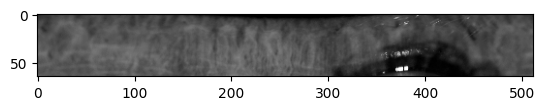

In [8]:

norm = normalize_iris(image_raw, x, y, radius_pupil, radius_iris)
plt.imshow(norm, cmap='gray')

In [15]:
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter1d

def gabor_wavelet_1d(size=31, f=3):
    sigma = 0.5 * np.pi * f
    x = np.linspace(-size // 2, size // 2, size)
    gabor = np.exp(-x**2 / (2 * sigma**2)) * np.cos(2 * np.pi * f * x)
    return gabor

    # def gabor_filter(size=31, f=3, orientation=0.0):
    #     sigma = 0.5 * np.pi * f
    #     x = np.linspace(-size // 2, size // 2, size)
    #     y = np.linspace(-size // 2, size // 2, size)
    #     x, y = np.meshgrid(x, y)
    #     x_theta = x * np.cos(orientation) + y * np.sin(orientation)
    #     y_theta = -x * np.sin(orientation) + y * np.cos(orientation)

    #     gb = np.exp(-(x_theta**2 + y_theta**2) / (2 * sigma**2)) * \
    #          np.cos(2 * np.pi * x_theta * f)

    #     return gb

def iris_code(normalized_iris, num_strips=8, f =3):
    num_strips = num_strips + 2 
    height, width = normalized_iris.shape
    strip_height = height // num_strips
    iris_code = []

    # gabor = gabor_filter(size=31, f = f, orientation=0)
    gabor = gabor_wavelet_1d(size=31, f=f)

    for i in range(1, num_strips - 1):  # pomijamy górny i dolny pasek
        start_row = i * strip_height
        end_row = (i + 1) * strip_height
        strip = normalized_iris[start_row:end_row, :]

        rect_width = strip.shape[1] // 128
        one_d_strip = []

        for j in range(128):
            start_col = j * rect_width
            end_col = (j + 1) * rect_width
            segment = strip[:, start_col:end_col]

            # Uśrednianie wzdłuż kolumny (czyli kierunek radialny)
            mean_intensity = segment.mean(axis=0)
            # Gaussowskie wygładzenie – radialne
            smoothed = gaussian_filter1d(mean_intensity, sigma=2)
            # Jedna wartość jako średnia z wygładzonego sygnału 1D
            value = np.mean(smoothed)

            one_d_strip.append(value)

        # Zamiana 1D sygnału na 1D kod binarny przy pomocy falki Gabora
        one_d_strip = np.array(one_d_strip) # 2D dla conv
        response = np.convolve(one_d_strip, gabor, mode='same')
        binary = (response > 0).astype(np.uint8).flatten()

        iris_code.append(binary)

    # Zwracamy kod jako macierz (pasy x 128 bitów)
    return np.array(iris_code)  

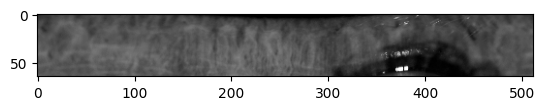

In [16]:
normalized = norm 
plt.imshow(normalized, cmap='gray')
normalized = normalize_iris(image, x, y, radius_pupil, radius_iris)




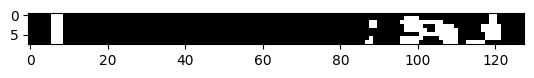

In [17]:
code = iris_code(normalized, f=3)
plt.imshow(code, cmap='gray')

## to chyba nie dziala zbyt dobrze


In [12]:
#hamming distance
def hamming_distance(code1, code2):
    """
    Calculate the Hamming distance between two binary codes.
    """
    return np.sum(code1 != code2)
hamming_distance(code1, code)

NameError: name 'code1' is not defined